In [54]:
# 📦 Required Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from skimage.feature import corner_harris, corner_peaks

# ✅ 1. Harris Corner Detection
def harris_corners(image, min_distance=10, threshold_rel=0.01):
    gray = np.array(image.convert('L')) / 255.0
    corner_response = corner_harris(gray)
    coords = corner_peaks(corner_response, min_distance=min_distance, threshold_rel=threshold_rel)
    return coords

# ✅ 2. Extract Descriptors Around Corner Points
def extract_descriptors(image, coords, patch_size=11):
    gray = np.array(image.convert('L')) / 255.0
    descriptors = []
    valid_coords = []
    offset = patch_size // 2
    for y, x in coords:
        if y - offset >= 0 and y + offset < gray.shape[0] and x - offset >= 0 and x + offset < gray.shape[1]:
            patch = gray[y - offset:y + offset + 1, x - offset:x + offset + 1].flatten()
            descriptors.append(patch)
            valid_coords.append((y, x))
    return np.array(descriptors), np.array(valid_coords)

# ✅ 3. Matching with Max Distance Constraint
def match_harris_points(desc1, locs1, desc2, locs2, max_dist=50):
    desc1 = (desc1 - np.mean(desc1, axis=1, keepdims=True)) / (np.std(desc1, axis=1, keepdims=True) + 1e-5)
    desc2 = (desc2 - np.mean(desc2, axis=1, keepdims=True)) / (np.std(desc2, axis=1, keepdims=True) + 1e-5)

    matches = []
    for i, row in enumerate(np.dot(desc1, desc2.T)):
        j = np.argmax(row)
        dist = np.linalg.norm(np.array(locs1[i]) - np.array(locs2[j]))
        if dist <= max_dist:
            matches.append((i, j))
    return np.array(matches)

# ✅ 4. Visualize Matches
def show_matches(im1, im2, locs1, locs2, matches):
    im1 = np.array(im1.convert('RGB'))
    im2 = np.array(im2.convert('RGB'))

    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    vis[:h1, :w1] = im1
    vis[:h2, w1:] = im2

    plt.figure(figsize=(12, 6))
    plt.imshow(vis)
    plt.axis('off')

    for i, j in matches:
        y1, x1 = locs1[i]
        y2, x2 = locs2[j]
        plt.plot([x1, x2 + w1], [y1, y2], 'r-', linewidth=1)
        plt.plot(x1, y1, 'go', markersize=3)
        plt.plot(x2 + w1, y2, 'bo', markersize=3)

    plt.title(f"Matched Points: {len(matches)}")
    plt.show()


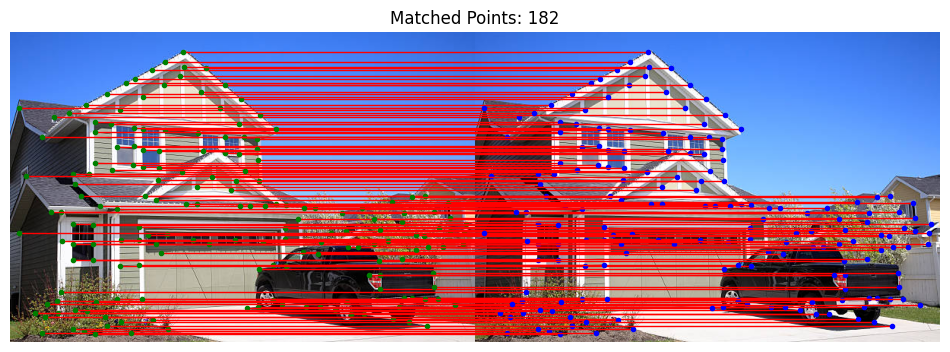

In [55]:
# Load your images (can be same or slightly modified versions)
im1 = Image.open("/content/istockphoto-180735173-612x612.jpg")
im2 = Image.open("/content/istockphoto-180735173-612x612.jpg")  # Replace with another if needed

# Detect Harris corners
coords1 = harris_corners(im1)
coords2 = harris_corners(im2)

# Extract patch descriptors
desc1, locs1 = extract_descriptors(im1, coords1)
desc2, locs2 = extract_descriptors(im2, coords2)

# Match descriptors with spatial filtering
matches = match_harris_points(desc1, locs1, desc2, locs2, max_dist=40)

# Show matches
show_matches(im1, im2, locs1, locs2, matches)


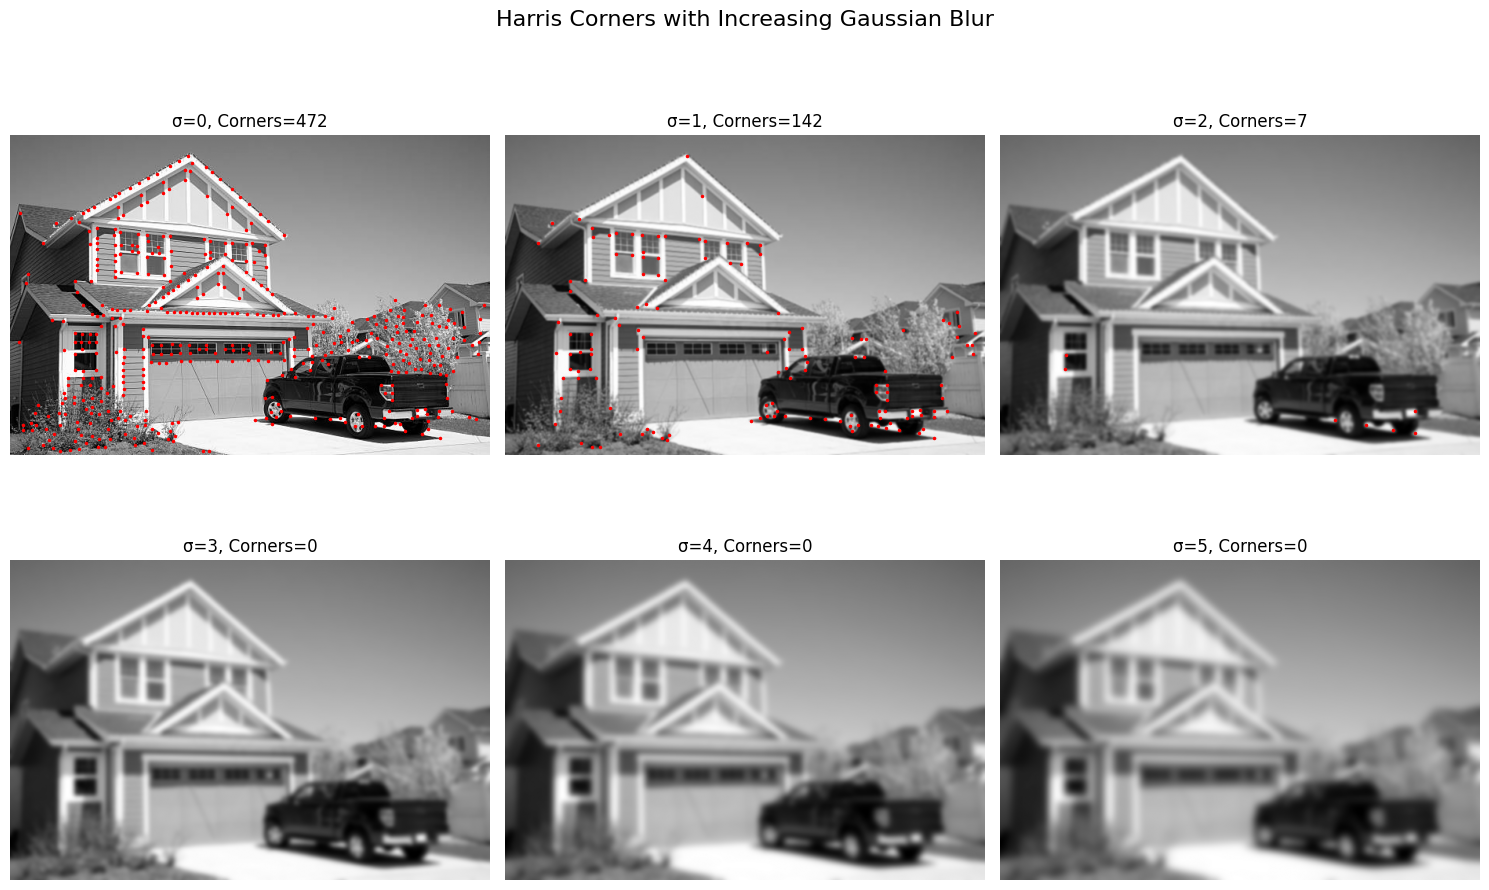

In [56]:
### Code: Harris Corners with Incremental Blur


import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.feature import corner_harris, corner_peaks

# Load image
image = Image.open("/content/istockphoto-180735173-612x612.jpg").convert('L')
image_np = np.array(image) / 255.0

# Blur levels to try
sigmas = [0, 1, 2, 3, 4, 5]

plt.figure(figsize=(15, 10))
for idx, sigma in enumerate(sigmas):
    # Apply Gaussian blur
    blurred = gaussian(image_np, sigma=sigma)

    # Harris corner detection
    response = corner_harris(blurred)
    coords = corner_peaks(response, min_distance=5, threshold_rel=0.01)

    # Plot
    plt.subplot(2, 3, idx+1)
    plt.imshow(blurred, cmap='gray')
    plt.plot(coords[:, 1], coords[:, 0], 'r.', markersize=3)
    plt.title(f'σ={sigma}, Corners={len(coords)}')
    plt.axis('off')

plt.suptitle("Harris Corners with Increasing Gaussian Blur", fontsize=16)
plt.tight_layout()
plt.show()

In [57]:
!pip install opencv-python-headless


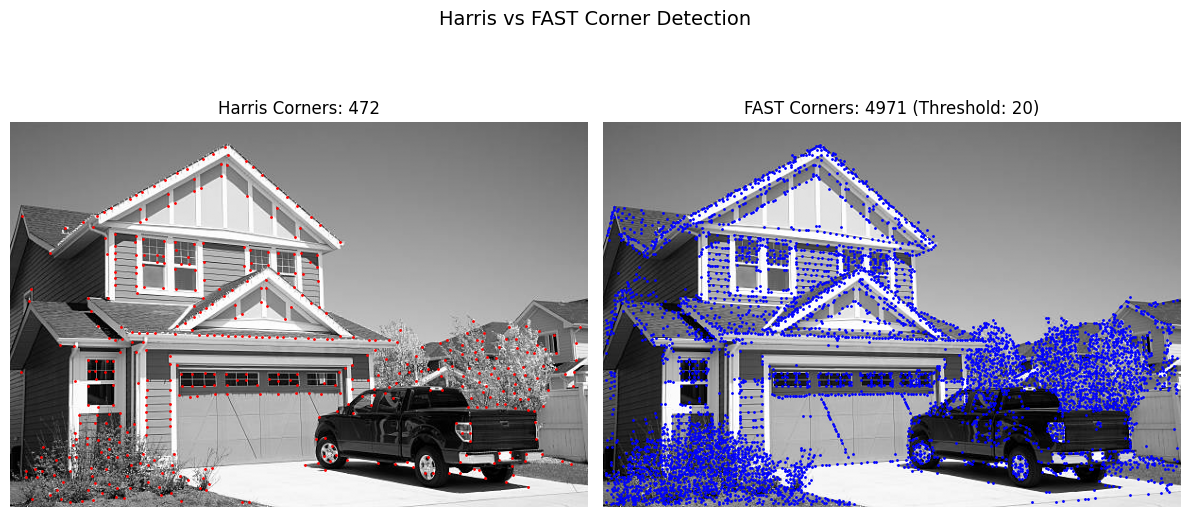

In [58]:
## compare fast vs harris

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import corner_harris, corner_peaks

# Load image and convert to grayscale
img = Image.open('/content/istockphoto-180735173-612x612.jpg').convert('L')
gray = np.array(img)

# --- Harris Detection ---
harris_resp = corner_harris(gray / 255.0)
harris_corners = corner_peaks(harris_resp, min_distance=5, threshold_rel=0.01)

# --- FAST Detection ---
fast = cv2.FastFeatureDetector_create(threshold=20)  # You can try thresholds like 5, 10, 30...
fast.setNonmaxSuppression(True)
keypoints = fast.detect(gray, None)

# Convert FAST keypoints to numpy (x, y)
fast_corners = np.array([kp.pt for kp in keypoints])

# --- Plot both detections ---
plt.figure(figsize=(12, 6))

# Harris
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.plot(harris_corners[:, 1], harris_corners[:, 0], 'r.', markersize=2)
plt.title(f"Harris Corners: {len(harris_corners)}")
plt.axis('off')

# FAST
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')
plt.plot(fast_corners[:, 0], fast_corners[:, 1], 'b.', markersize=2)
plt.title(f"FAST Corners: {len(fast_corners)} (Threshold: 20)")
plt.axis('off')

plt.suptitle("Harris vs FAST Corner Detection", fontsize=14)
plt.tight_layout()
plt.show()


In [59]:
!pip install opencv-contrib-python


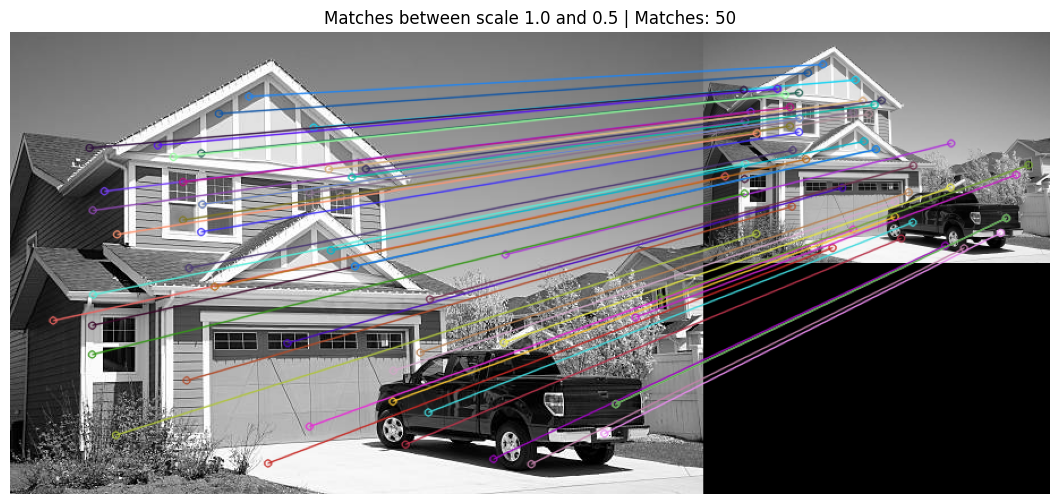

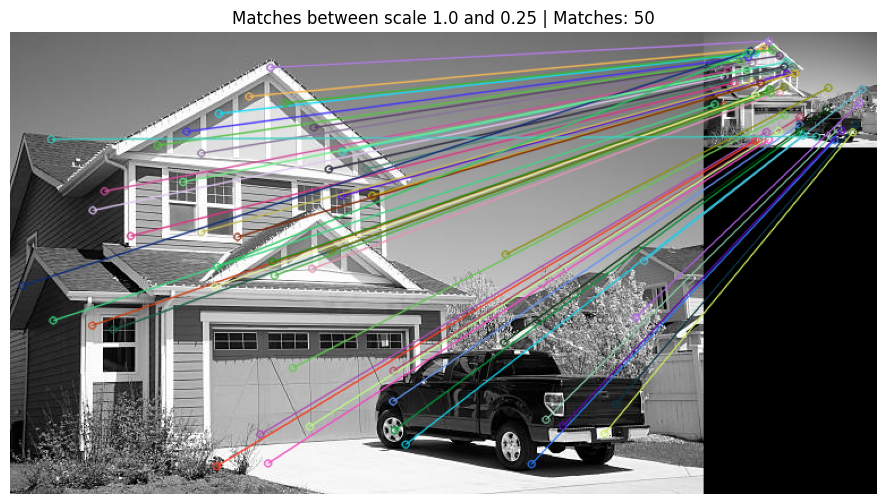

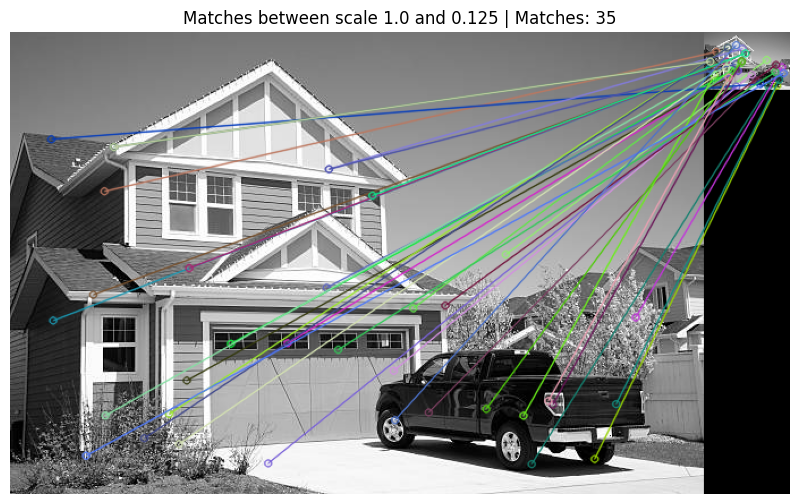

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load original image
image_path = "/content/istockphoto-180735173-612x612.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Create resized copies
scales = [1.0, 0.5, 0.25, 0.125]
images = [cv2.resize(img, (0, 0), fx=s, fy=s) for s in scales]

# Extract features
keypoints_list = []
descriptors_list = []
for img_scaled in images:
    kp, des = sift.detectAndCompute(img_scaled, None)
    keypoints_list.append(kp)
    descriptors_list.append(des)

# BFMatcher for descriptor matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Plot and match features to original image
for i in range(1, len(scales)):
    matches = bf.match(descriptors_list[0], descriptors_list[i])
    matches = sorted(matches, key=lambda x: x.distance)[:50]

    matched_img = cv2.drawMatches(
        images[0], keypoints_list[0],
        images[i], keypoints_list[i],
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 6))
    plt.imshow(matched_img[..., ::-1])
    plt.title(f'Matches between scale 1.0 and {scales[i]} | Matches: {len(matches)}')
    plt.axis('off')
    plt.show()


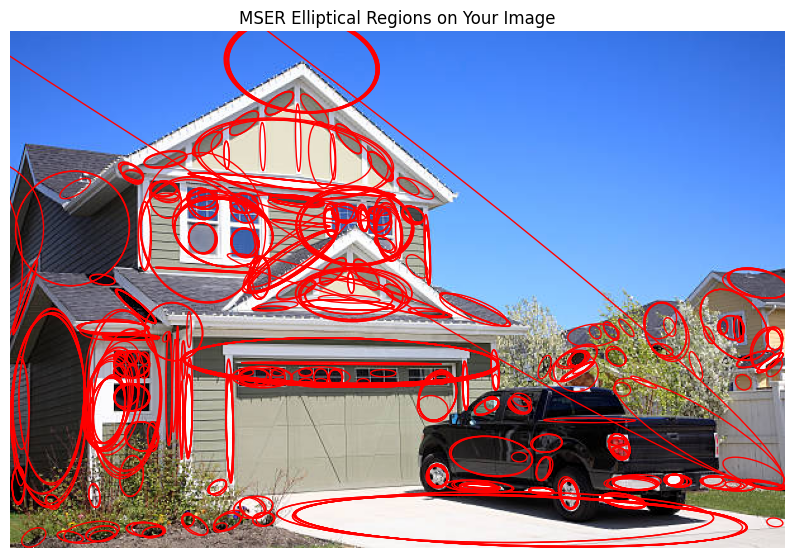

 Extracted 565450 MSER keypoints.
 Found 565450 SIFT descriptors.


In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Load your image
image_path = '/content/istockphoto-180735173-612x612.jpg'
img = cv2.imread(image_path)
if img is None:
    raise ValueError("Image not found or cannot be opened.")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Function to extract MSER keypoints and regions ---
def extract_mser_regions(gray_img):
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(gray_img)
    keypoints = [cv2.KeyPoint(float(x), float(y), 1) for region in regions for (x, y) in region]
    return keypoints, regions

# --- Function to compute SIFT descriptors at MSER keypoints ---
def compute_sift_descriptors(gray_img, keypoints):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.compute(gray_img, keypoints)
    return keypoints, descriptors

# --- Function to plot MSER ellipses ---
def plot_mser_ellipses(image, regions):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for region in regions:
        if len(region) < 5:
            continue  # fitEllipse requires at least 5 points
        region = np.array(region)
        ellipse = cv2.fitEllipse(region)
        (x, y), (MA, ma), angle = ellipse
        ell = Ellipse((x, y), MA, ma, angle=angle, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(ell)

    plt.title("MSER Elliptical Regions on Your Image")
    plt.axis('off')
    plt.show()

# --- Full Pipeline ---
mser_kp, mser_regions = extract_mser_regions(gray)
mser_kp, descriptors = compute_sift_descriptors(gray, mser_kp)
plot_mser_ellipses(img, mser_regions)

print(f" Extracted {len(mser_kp)} MSER keypoints.")
print(f" Found {descriptors.shape[0] if descriptors is not None else 0} SIFT descriptors.")


 Estimated Scale Change: 1.700
 Estimated In-plane Rotation: -107.02 degrees


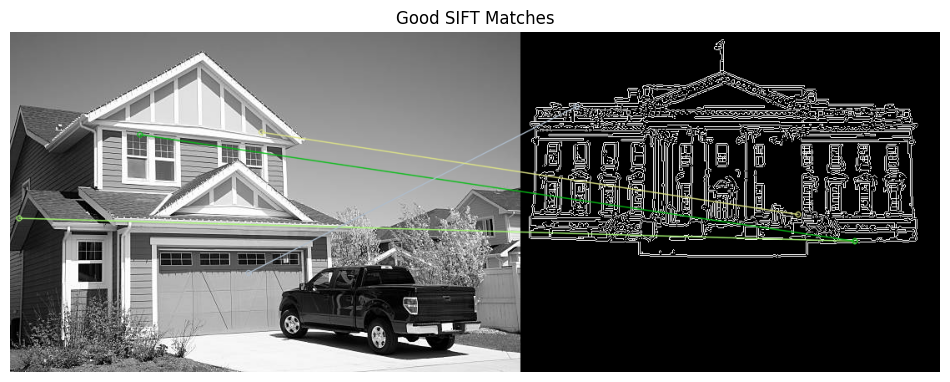

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def estimate_scale_rotation(img1_path, img2_path):
    # Load images
    img1 = cv2.imread(img1_path, 0)  # Grayscale
    img2 = cv2.imread(img2_path, 0)

    if img1 is None or img2 is None:
        raise ValueError("Image not found or cannot be loaded")

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Match features using FLANN + Lowe's ratio test
    index_params = dict(algorithm=1, trees=5)  # KDTree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    if len(good) < 4:
        print("Not enough matches found.")
        return

    # Extract location of good matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Estimate affine transform using RANSAC
    matrix, inliers = cv2.estimateAffine2D(pts1, pts2, method=cv2.RANSAC)

    if matrix is None:
        print("Affine transformation could not be estimated.")
        return

    # Extract scale and rotation from matrix
    a = matrix[0, 0]
    b = matrix[0, 1]

    scale = np.sqrt(a ** 2 + b ** 2)
    rotation_rad = np.arctan2(b, a)
    rotation_deg = np.degrees(rotation_rad)

    print(f" Estimated Scale Change: {scale:.3f}")
    print(f" Estimated In-plane Rotation: {rotation_deg:.2f} degrees")

    # Optional: Visualize matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=2)
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.title("Good SIFT Matches")
    plt.axis('off')
    plt.show()

# Example usage:
estimate_scale_rotation(
    '/content/istockphoto-180735173-612x612.jpg',
    '/content/121-1217048_under-this-roof-white-house-renovation-timeline-hd.png'
)


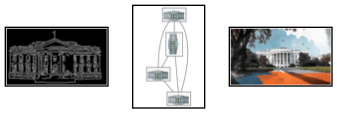

In [71]:
import pydot
from PIL import Image
import cv2
import os
from IPython.display import display
from io import BytesIO
import matplotlib.pyplot as plt

# Sample image paths (use your real image paths here)
img_paths = [
    "/content/121-1217048_under-this-roof-white-house-renovation-timeline-hd.png",
    "/content/whitehouse_sim_graph.png",
    "/content/whitehouse1.jpg"
]

# Create thumbnail directory
thumb_folder = "/content/thumbs"
os.makedirs(thumb_folder, exist_ok=True)

# Initialize graph
g = pydot.Dot(graph_type='graph')
threshold = 10

# Function to compute good matches
def good_matches(img1_path, img2_path):
    img1 = cv2.imread(img1_path, 0)
    img2 = cv2.imread(img2_path, 0)
    if img1 is None or img2 is None:
        return 0
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), {})
    matches = flann.knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return len(good)

# Add nodes (images)
for i, path in enumerate(img_paths):
    img = Image.open(path)
    img.thumbnail((100, 100))
    thumb_path = f"{thumb_folder}/thumb_{i}.png"
    img.save(thumb_path)
    g.add_node(pydot.Node(str(i), image=thumb_path, shape='rectangle', fontcolor='transparent'))

# Add edges based on match threshold
for i in range(len(img_paths)):
    for j in range(i + 1, len(img_paths)):
        score = good_matches(img_paths[i], img_paths[j])
        if score > threshold:
            g.add_edge(pydot.Edge(str(i), str(j), label=str(score)))

# Display graph inline (without saving)
png_str = g.create(format='png')
img = Image.open(BytesIO(png_str))
display(img)
